In [23]:
%matplotlib inline
import torch
import torch.nn as nn
import d2l.torch as d2l

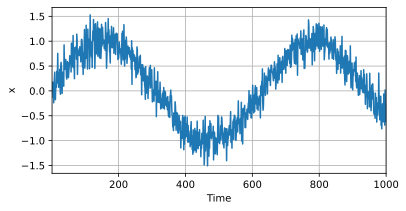

In [24]:
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'Time', 'x', xlim=[1, 1000], figsize=(6, 3), )

### 生成“特征-标签”（feature-label）数据对

In [25]:
tau = 4
features = torch.zeros((T - tau, tau))
features1 = torch.zeros((T - tau, tau))
for i in range(T-tau):
    features[i, :] = x[i : i+4]

labels = x[tau:].reshape((-1,1))

batch_size, n_train = 16, 600
my_dataset = torch.utils.data.TensorDataset(features[:n_train], labels[:n_train])
train_iter = torch.utils.data.DataLoader(my_dataset, batch_size, shuffle=True)

### 训练

In [26]:
# 初始化网络权重
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 定义简单多层感知机网络
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(), 
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

# 训练：对于下一步的预测都是基于给定的原始数据而非网络预测的数据
loss = nn.MSELoss(reduction='none')

def train(net, train_iter, loss, num_epochs, lr):
    optimizer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            optimizer.step()
        print(f'epoch {epoch+1}'+'\t'+f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1	loss: 0.063674
epoch 2	loss: 0.057534
epoch 3	loss: 0.057006
epoch 4	loss: 0.056838
epoch 5	loss: 0.055798


### 单步预测

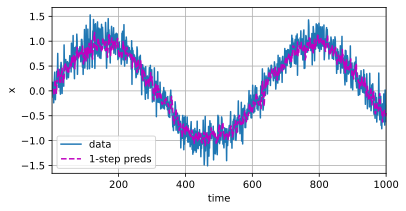

In [27]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

### 多步预测

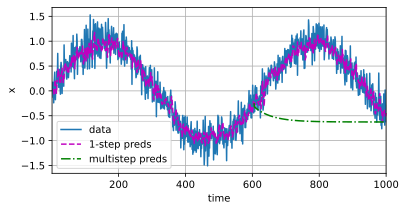

In [28]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau]
# 使用预测得到的数据进行下一步预测 onestep_preds:k=1
for i in range(n_train+tau, T):
    multistep_preds[i] = net(
        # 将预测得到的数据用于下一步的预测, 
        multistep_preds[i-tau:i].reshape([1, -1])
    )

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

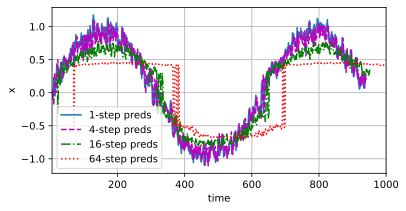

In [29]:
# 多步预测
maxstep = 64
features = torch.zeros((T-tau-maxstep+1, tau+maxstep))
for i in range(tau):
    features[:, i] = x[i:i+T-tau-maxstep+1]
for i in range(tau, tau+maxstep):
    features[:, i] = net(features[:, i-tau:i]).reshape(-1)

steps = [1, 4, 16, 64]
d2l.plot(
    [time[tau+i-1 : T-maxstep+i] for i in steps],
    [features[:, tau+i-1].detach().numpy() for i in steps],
    'time', 'x',
    legend=[f'{i}-step preds' for i in steps], 
    xlim=[5, 1000],
    figsize=(6, 3)
)